In [1]:
import os
import gc
import sys
import glob
import time
import tqdm
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 量的データの標準化
from sklearn.preprocessing import StandardScaler
# K-Prototypeクラスタリング
from kmodes.kprototypes import KPrototypes
# Gower距離
import gower
# 階層クラスタリング
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

#グラフのスタイル
plt.style.use('bmh')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [2]:
# dehdrogramを作るメソッド。以下のsklearnのサイトから転記
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# データ読み込みと前処理

In [3]:
df0 = pd.read_csv('./rawdata/Low_Birth_Weight_Infants.csv')
df0.head()

,MotherID,Low,Age,LWT,Race,Smoker,PTL,Hypertension,UI,FTV,BWT
0,85,False,"Quantity[19, ""Years""]","Quantity[182, ""Pounds""]",2,False,0,False,True,0,"Quantity[2523, ""Grams""]"
1,86,False,"Quantity[33, ""Years""]","Quantity[155, ""Pounds""]",3,False,0,False,False,3,"Quantity[2551, ""Grams""]"
2,87,False,"Quantity[20, ""Years""]","Quantity[105, ""Pounds""]",1,True,0,False,False,1,"Quantity[2557, ""Grams""]"
3,88,False,"Quantity[21, ""Years""]","Quantity[108, ""Pounds""]",1,True,0,False,True,2,"Quantity[2594, ""Grams""]"
4,89,False,"Quantity[18, ""Years""]","Quantity[107, ""Pounds""]",1,True,0,False,True,0,"Quantity[2600, ""Grams""]"


In [4]:
# 必要な数値を取り出す、TrueとFalseを0,1に変換

df = df0[["MotherID"]].copy()
df.rename(columns={"MotherID":"ID"}, inplace=True)
df["low"] = df0["Low"]+0
df["age"] = df0["Age"].apply(lambda x:int(x[9:x.find(",")]))
df["lwt"] = df0["LWT"].apply(lambda x:int(x[9:x.find(",")]))
df["race"] = df0["Race"]
df["smoke"] = df0["Smoker"]#+1
df["ptl"] = df0["PTL"]
df["ht"] = df0["Hypertension"]#+0 #高血圧歴
df["ui"] = df0["UI"]#+0

In [5]:
df.head()

,ID,low,age,lwt,race,smoke,ptl,ht,ui
0,85,0,19,182,2,False,0,False,True
1,86,0,33,155,3,False,0,False,False
2,87,0,20,105,1,True,0,False,False
3,88,0,21,108,1,True,0,False,True
4,89,0,18,107,1,True,0,False,True


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      189 non-null    int64
 1   low     189 non-null    int32
 2   age     189 non-null    int64
 3   lwt     189 non-null    int64
 4   race    189 non-null    int64
 5   smoke   189 non-null    bool 
 6   ptl     189 non-null    int64
 7   ht      189 non-null    bool 
 8   ui      189 non-null    bool 
dtypes: bool(3), int32(1), int64(5)
memory usage: 8.8 KB


In [7]:
# カテゴリカル特徴量は文字型にしておく
df['race'] = df['race'].astype(str)
df['smoke'] = df['smoke'].astype(str)
df['ht'] = df['ht'].astype(str)
df['ui'] = df['ui'].astype(str)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      189 non-null    int64 
 1   low     189 non-null    int32 
 2   age     189 non-null    int64 
 3   lwt     189 non-null    int64 
 4   race    189 non-null    object
 5   smoke   189 non-null    object
 6   ptl     189 non-null    int64 
 7   ht      189 non-null    object
 8   ui      189 non-null    object
dtypes: int32(1), int64(4), object(4)
memory usage: 12.7+ KB


In [9]:
X = df.drop(columns=['low', 'ID'])

In [10]:
X.head()

,age,lwt,race,smoke,ptl,ht,ui
0,19,182,2,False,0,False,True
1,33,155,3,False,0,False,False
2,20,105,1,True,0,False,False
3,21,108,1,True,0,False,True
4,18,107,1,True,0,False,True


Numeric : age


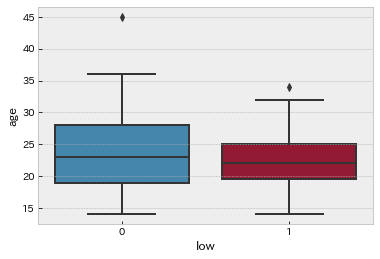

,low,count,age
0,0,130,23.661538
1,1,59,22.305085


------------------------
Numeric : lwt


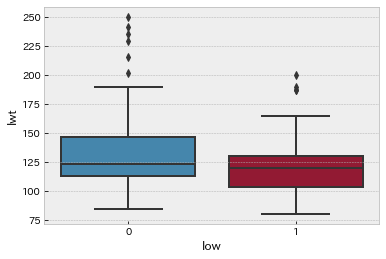

,low,count,lwt
0,0,130,133.300000
1,1,59,122.135593


------------------------
Categorical : race


low,race,0,1,total,fraction
0,1,73,23,96,0.760417
1,2,15,11,26,0.576923
2,3,42,25,67,0.626866


------------------------
Categorical : smoke


low,smoke,0,1,total,fraction
0,False,86,29,115,0.747826
1,True,44,30,74,0.594595


------------------------
Numeric : ptl


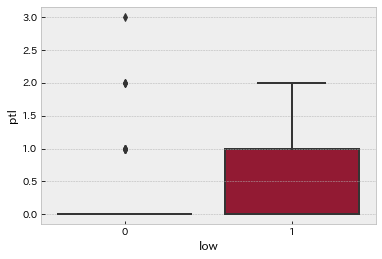

,low,count,ptl
0,0,130,0.130769
1,1,59,0.338983


------------------------
Categorical : ht


low,ht,0,1,total,fraction
0,False,125,52,177,0.706215
1,True,5,7,12,0.416667


------------------------
Categorical : ui


low,ui,0,1,total,fraction
0,False,116,45,161,0.720497
1,True,14,14,28,0.500000


------------------------


In [12]:
for col in X.columns:
    
    if df[col].dtype == 'object':
        print('Categorical :', col)
        _df_tmp = pd.pivot_table(data=df, index=col, columns=['low'], values='ID', aggfunc='count').reset_index() 
    #     print(_df_tmp.columns)
        _df_tmp['total'] = _df_tmp[0] + _df_tmp[1]
        _df_tmp['fraction'] = _df_tmp[0] / (_df_tmp[0] + _df_tmp[1]) 

    else:
        print('Numeric :', col)
        _df_tmp = df[[col, 'low']].groupby('low').agg({
            'low':'count',
            col:'mean'
        }).rename(columns={'low':'count'}).reset_index()
        
        sns.boxplot(x='low', y=col, data=df)
        plt.show()
        plt.close()

    display(_df_tmp)

    print("------------------------")


### 量的変数には正規化を実施

In [13]:
X_numerical = X[['age', 'lwt', 'ptl']]
X_categorical = X[['race', 'smoke', 'ht', 'ui']]

stdscl = StandardScaler()
X_numerical_scl = pd.DataFrame( stdscl.fit_transform(X_numerical) , columns=X_numerical.columns)
X_numerical_scl.head()

,age,lwt,ptl
0,-0.801965,1.711081,-0.397872
1,1.847222,0.825788,-0.397872
2,-0.612737,-0.813644,-0.397872
3,-0.423509,-0.715278,-0.397872
4,-0.991192,-0.748067,-0.397872


In [14]:
X_scl =pd.concat([X_numerical_scl, X_categorical], axis=1)
X_scl.head()

,age,lwt,ptl,race,smoke,ht,ui
0,-0.801965,1.711081,-0.397872,2,False,False,True
1,1.847222,0.825788,-0.397872,3,False,False,False
2,-0.612737,-0.813644,-0.397872,1,True,False,False
3,-0.423509,-0.715278,-0.397872,1,True,False,True
4,-0.991192,-0.748067,-0.397872,1,True,False,True


# K-Prototype

### K-Prototypeの引数に必要となる、質的変数のカラム位置を求める

In [15]:
catColumnsPos = [ X_scl.columns.get_loc(col) for col in list(X_scl.select_dtypes('object').columns) ]
catColumnsPos

[3, 4, 5, 6]

In [16]:
list_n_cluster = []
list_cost = []
for _n in tqdm.tqdm(range(1,16,1)):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = _n, init = 'Huang', random_state = 0)
        kprototype.fit_predict(X_scl, categorical = catColumnsPos)
        list_n_cluster.append(_n)
        list_cost.append(kprototype.cost_)
    except:
        break

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.77it/s]


Text(0, 0.5, 'cost')

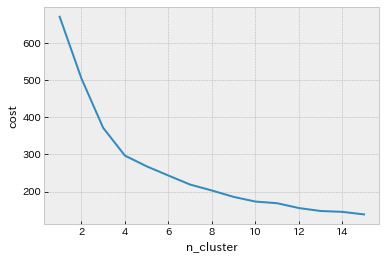

In [30]:
plt.plot(list_n_cluster, list_cost)
plt.xlabel('n_cluster')
plt.ylabel('cost')

#### クラスタ数は10が妥当か、クラスタ数10で確認

In [18]:
kprototype = KPrototypes(n_jobs = -1, n_clusters = 10, init = 'Huang', random_state = 0)
kprototype.fit_predict(X_scl, categorical = catColumnsPos)

array([5, 0, 7, 7, 7, 1, 4, 1, 8, 4, 1, 1, 1, 9, 7, 7, 1, 4, 1, 8, 8, 8,
       0, 8, 4, 0, 7, 0, 0, 1, 1, 2, 9, 0, 4, 8, 7, 4, 3, 8, 5, 5, 4, 5,
       7, 7, 8, 1, 4, 7, 4, 4, 7, 8, 1, 1, 7, 0, 1, 1, 1, 4, 4, 8, 6, 2,
       4, 3, 6, 2, 6, 0, 7, 1, 7, 3, 4, 9, 7, 3, 4, 0, 8, 1, 4, 1, 1, 4,
       0, 4, 4, 1, 3, 6, 7, 8, 0, 5, 5, 8, 4, 5, 2, 4, 1, 3, 8, 5, 7, 5,
       0, 1, 8, 8, 5, 8, 1, 8, 4, 1, 5, 0, 4, 4, 4, 8, 9, 7, 4, 8, 9, 8,
       0, 2, 4, 0, 4, 2, 4, 5, 8, 6, 4, 1, 4, 5, 3, 9, 1, 1, 6, 7, 7, 9,
       4, 2, 7, 2, 4, 7, 7, 2, 1, 1, 2, 2, 2, 4, 9, 1, 5, 7, 4, 1, 4, 9,
       7, 7, 2, 1, 9, 1, 3, 2, 8, 1, 7, 1, 7], dtype=uint16)

In [19]:
df_KProto = df[['ID', 'low']]
df_KProto = pd.concat([df_KProto, X], axis=1)
df_KProto['label'] = kprototype.labels_
df_KProto.head()

,ID,low,age,lwt,race,smoke,ptl,ht,ui,label
0,85,0,19,182,2,False,0,False,True,5
1,86,0,33,155,3,False,0,False,False,0
2,87,0,20,105,1,True,0,False,False,7
3,88,0,21,108,1,True,0,False,True,7
4,89,0,18,107,1,True,0,False,True,7


In [20]:
df_KProto_cluster = df_KProto.groupby('label').agg(
    {
        'label':'count',
        'low': 'mean',
        'age': 'mean',
        'lwt': 'mean',
        'race': lambda x: x.value_counts().index[0],
        'smoke': lambda x: x.value_counts().index[0],
        'ptl': 'mean',
        'ht': lambda x: x.value_counts().index[0],
        'ui': lambda x: x.value_counts().index[0]
    }
).rename(columns={'label':'Count'}).reset_index()
df_KProto_cluster = df_KProto_cluster.sort_values('low').reset_index(drop=True)
df_KProto_cluster['label2'] = df_KProto_cluster.index
df_KProto_cluster



,label,Count,low,age,lwt,race,smoke,ptl,ht,ui,label2
0,8,23,0.130435,30.521739,120.782609,1,False,0.000000,False,False,0
1,0,15,0.133333,30.266667,165.466667,1,False,0.000000,False,False,1
2,5,14,0.214286,19.928571,168.785714,1,True,0.000000,False,False,2
3,3,8,0.250000,23.875000,218.750000,1,True,0.000000,False,False,3
4,4,36,0.277778,23.944444,118.805556,1,False,0.000000,False,False,4
5,1,35,0.314286,17.971429,116.685714,3,False,0.000000,False,False,5
6,6,6,0.333333,22.833333,110.166667,1,True,2.166667,False,False,6
7,7,28,0.357143,19.357143,112.535714,1,True,0.000000,False,False,7
8,9,10,0.600000,29.700000,132.200000,1,True,1.000000,False,False,8
9,2,14,0.714286,21.357143,119.071429,3,True,1.000000,False,False,9


In [21]:
df_KProto = pd.merge(df_KProto, df_KProto_cluster[['label', 'label2']], on='label', how='inner')
df_KProto.head()

,ID,low,age,lwt,race,smoke,ptl,ht,ui,label,label2
0,85,0,19,182,2,False,0,False,True,5,2
1,128,0,21,185,2,True,0,False,False,5,2
2,129,0,19,189,1,False,0,False,False,5,2
3,131,0,21,160,1,False,0,False,False,5,2
4,192,0,19,147,1,True,0,False,False,5,2


# Gower距離による階層クラスタリング

In [22]:
X_distance = gower.gower_matrix(X_scl)
X_distance

array([[0.        , 0.3729195 , 0.4978856 , ..., 0.5209542 , 0.32854432,
        0.6243426 ],
       [0.3729195 , 0.        , 0.38763893, ..., 0.2402006 , 0.37037137,
        0.50487936],
       [0.4978856 , 0.38763893, 0.        , ..., 0.16592573, 0.47348875,
        0.16847384],
       ...,
       [0.5209542 , 0.2402006 , 0.16592573, ..., 0.        , 0.49655733,
        0.32518297],
       [0.32854432, 0.37037137, 0.47348875, ..., 0.49655733, 0.        ,
        0.3142315 ],
       [0.6243426 , 0.50487936, 0.16847384, ..., 0.32518297, 0.3142315 ,
        0.        ]], dtype=float32)

In [23]:
AggCluster = AgglomerativeClustering(n_clusters=10, linkage='complete',
                                affinity='precomputed', compute_distances=True)
AggCluster.fit(X_distance)

AgglomerativeClustering(affinity='precomputed', compute_distances=True,
                        linkage='complete', n_clusters=10)

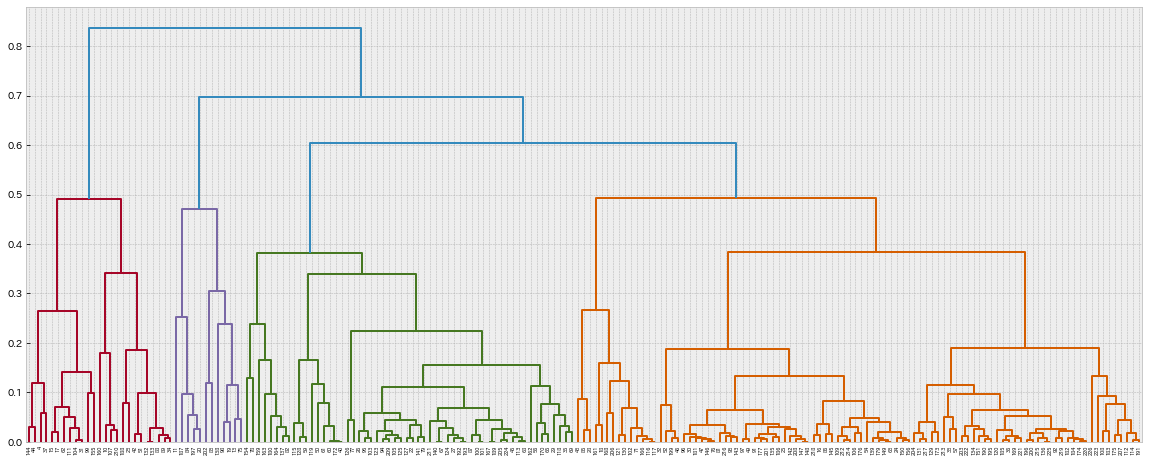

In [24]:
labels = df['ID'].tolist()
plt.figure(figsize=(20,8))
plot_dendrogram(AggCluster, labels=labels)

In [25]:
df_KAggCat = df[['ID', 'low']]
df_KAggCat = pd.concat([df_KAggCat, X], axis=1)
df_KAggCat['label'] = AggCluster.fit_predict(X_distance) 
df_KAggCat.head()

,ID,low,age,lwt,race,smoke,ptl,ht,ui,label
0,85,0,19,182,2,False,0,False,True,4
1,86,0,33,155,3,False,0,False,False,7
2,87,0,20,105,1,True,0,False,False,0
3,88,0,21,108,1,True,0,False,True,5
4,89,0,18,107,1,True,0,False,True,5


In [26]:
df_KAggCat_cluster = df_KAggCat.groupby('label').agg(
    {
        'label':'count',
        'low': 'mean',
        'age': 'mean',
        'lwt': 'mean',
        'race': lambda x: x.value_counts().index[0],
        'smoke': lambda x: x.value_counts().index[0],
        'ptl': 'mean',
        'ht': lambda x: x.value_counts().index[0],
        'ui': lambda x: x.value_counts().index[0]
    }
).rename(columns={'label':'Count'}).reset_index()
df_KAggCat_cluster = df_KAggCat_cluster.sort_values('low').reset_index(drop=True)
df_KAggCat_cluster['label2'] = df_KAggCat_cluster.index
df_KAggCat_cluster

,label,Count,low,age,lwt,race,smoke,ptl,ht,ui,label2
0,8,39,0.076923,25.897436,141.051282,1,False,0.025641,False,False,0
1,3,8,0.250000,23.000000,131.000000,3,True,0.375000,False,False,1
2,9,4,0.250000,28.250000,122.000000,1,False,0.500000,False,True,2
3,4,14,0.285714,19.785714,143.428571,2,False,0.142857,False,False,3
4,7,43,0.302326,22.209302,119.279070,3,False,0.116279,False,False,4
5,0,48,0.375000,23.625000,128.104167,1,True,0.229167,False,False,5
6,5,9,0.444444,20.000000,104.888889,1,True,0.777778,False,True,6
7,1,7,0.571429,23.000000,141.285714,3,False,0.285714,True,False,7
8,2,12,0.583333,22.000000,114.833333,3,False,0.333333,False,True,8
9,6,5,0.600000,22.800000,180.200000,1,True,0.000000,True,False,9


In [27]:
df_KAggCat = pd.merge(df_KAggCat, df_KAggCat_cluster[['label', 'label2']], on='label', how='inner')
df_KAggCat.head()

,ID,low,age,lwt,race,smoke,ptl,ht,ui,label,label2
0,85,0,19,182,2,False,0,False,True,4,3
1,102,0,15,98,2,False,0,False,False,4,3
2,116,0,17,113,2,False,0,False,False,4,3
3,117,0,17,113,2,False,0,False,False,4,3
4,121,0,25,125,2,False,0,False,False,4,3


## 2つのクラスタリング手法を比較

In [28]:
pd.crosstab(df_KProto['label2'], df_KAggCat['label2'])

label2,0,1,2,3,4,5,6,7,8,9
label2,,,,,,,,,,
0,23,0,0,0,0,0,0,0,0,0
1,0,0,0,0,15,0,0,0,0,0
2,0,0,0,14,0,0,0,0,0,0
3,0,7,1,0,0,0,0,0,0,0
4,14,0,0,0,0,13,9,0,0,0
5,0,0,0,0,0,35,0,0,0,0
6,0,1,0,0,0,0,0,0,0,5
7,0,0,0,0,28,0,0,0,0,0
8,2,0,0,0,0,0,0,7,1,0
